In [1]:
import os
import zipfile
import json
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 32
EPSILONS = {'fgsm': 0.02, 'pgd': 0.02, 'patch': 0.3}
PATCH_SIZE = 32
PGD_ITERATIONS = 10
ALPHA = 0.005  # Step size for PGD

print(f"Using device: {DEVICE}")
import urllib.request

def download_imagenet_class_index():
    url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
    filename = "imagenet_class_index.json"
    if not os.path.exists(filename):
        print("Downloading ImageNet class index...")
        urllib.request.urlretrieve(url, filename)
        print("Download complete.")
    return filename

# Call this before loading class labels
download_imagenet_class_index()



Using device: cuda
Download complete.


'imagenet_class_index.json'

In [2]:

# Function to extract dataset if needed
def extract_dataset(zip_path, extract_dir):
    if not os.path.exists(os.path.join(extract_dir, "TestDataSet")):
        print(f"Extracting {zip_path} to {extract_dir}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Extraction complete.")
    else:
        print("Dataset already extracted.")
    return os.path.join(extract_dir, "TestDataSet")

# Extract dataset
zip_path = "TestDataSet.zip"  # Adjust path if needed
extract_dir = "."
dataset_path = extract_dataset(zip_path, extract_dir)

# Load class labels
try:
    with open(os.path.join(extract_dir, "imagenet_class_index.json"), 'r') as f:
        class_idx = json.load(f)
    class_names = {int(k): v[1] for k, v in class_idx.items()}
    print(f"Loaded {len(class_names)} class names")
except FileNotFoundError:
    print("Warning: Class index file not found. Will use numeric indices.")
    class_names = None

# Data preprocessing
def get_data_loader(dataset_path, transform=None, batch_size=BATCH_SIZE):
    if transform is None:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ])

    # Load original dataset
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

    # Load ImageNet class mapping
    with open("imagenet_class_index.json", "r") as f:
        class_index = json.load(f)

    # Map: WordNet ID -> ImageNet index
    wnid_to_idx = {v[0]: int(k) for k, v in class_index.items()}

    # Remap dataset class_to_idx using WordNet IDs in folder names
    new_class_to_idx = {}
    for class_name in dataset.class_to_idx.keys():
        if class_name in wnid_to_idx:
            new_class_to_idx[class_name] = wnid_to_idx[class_name]
        else:
            print(f"Warning: {class_name} not in ImageNet index file.")

    dataset.class_to_idx = new_class_to_idx

    # Rebuild dataset.samples with correct targets
    dataset.samples = [(path, new_class_to_idx[dataset.classes[cls]])
                   for path, cls in dataset.samples
                   if dataset.classes[cls] in new_class_to_idx]


    dataset.targets = [target for _, target in dataset.samples]

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    print(f"Dataset loaded with {len(dataset)} images and {len(new_class_to_idx)} mapped classes.")
    return loader, dataset




Extracting TestDataSet.zip to ....
Extraction complete.
Loaded 1000 class names


In [3]:
# Utility classes and functions
class CustomDataset(Dataset):
    def __init__(self, tensor_data, targets):
        self.data = tensor_data
        self.targets = targets
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx], self.targets[idx]

def denormalize(tensor):
    """Convert normalized image tensor back to 0-1 range for visualization"""
    mean = torch.tensor(MEAN, device=tensor.device).view(-1, 1, 1)
    std = torch.tensor(STD, device=tensor.device).view(-1, 1, 1)
    return torch.clamp(tensor * std + mean, 0, 1)

def evaluate(model, loader):
    """Evaluate model accuracy on a data loader"""
    model.eval()
    top1, top5, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.topk(outputs, k=5, dim=1)
            total += labels.size(0)
            top1 += (preds[:, 0] == labels).sum().item()
            top5 += (preds == labels.view(-1, 1)).sum().item()
    return top1 / total, top5 / total

def visualize_comparison(originals, adversarials, attack_name, predictions=None, true_labels=None):
    """Visualize original vs adversarial images with predictions"""
    plt.figure(figsize=(15, 6))
    num_images = min(3, originals.shape[0])

    for i in range(num_images):
        orig = denormalize(originals[i].detach().cpu()).permute(1, 2, 0).numpy()
        adv = denormalize(adversarials[i].detach().cpu()).permute(1, 2, 0).numpy()

        # Calculate PSNR
        mse = np.mean((orig - adv) ** 2)
        max_pixel = 1.0
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

        plt.subplot(2, num_images, i+1)
        plt.imshow(orig)
        title = "Original"
        if predictions is not None and true_labels is not None:
            orig_pred = predictions['original'][i]
            orig_label = class_names[orig_pred.item()] if class_names else f"Class {orig_pred.item()}"
            true_label = class_names[true_labels[i].item()] if class_names else f"Class {true_labels[i].item()}"
            title += f"\nPred: {orig_label}\nTrue: {true_label}"
        plt.title(title)
        plt.axis('off')

        plt.subplot(2, num_images, i+num_images+1)
        plt.imshow(adv)
        title = f"{attack_name.upper()} Attack\nPSNR: {psnr:.2f} dB"
        if predictions is not None:
            adv_pred = predictions['adversarial'][i]
            adv_label = class_names[adv_pred.item()] if class_names else f"Class {adv_pred.item()}"
            title += f"\nPred: {adv_label}"
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def get_predictions(model, images, k=1):
    """Get top-k predictions for a batch of images"""
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.topk(outputs, k=k, dim=1)
    return preds

# Adversarial Attack Implementations
def fgsm_attack(model, images, labels, epsilon):
    """Fast Gradient Sign Method attack"""
    model.eval()
    images.requires_grad = True
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()
    # Create adversarial examples
    perturbed_images = images + epsilon * images.grad.sign()
    # Clip to ensure valid range
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images.detach()

def pgd_attack(model, images, labels, epsilon, alpha, num_iter):
    """Projected Gradient Descent attack"""
    model.eval()
    orig_images = images.clone().detach()
    perturbed_images = images.clone().detach()

    for _ in range(num_iter):
        perturbed_images.requires_grad = True
        outputs = model(perturbed_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            # Take a step in the gradient direction
            adv = perturbed_images + alpha * perturbed_images.grad.sign()
            # Project back to epsilon-ball around original image
            eta = torch.clamp(adv - orig_images, -epsilon, epsilon)
            perturbed_images = torch.clamp(orig_images + eta, 0, 1)

    return perturbed_images.detach()

def targeted_pgd_attack(model, images, labels, epsilon, alpha, num_iter, target_class=None):
    """Targeted PGD attack that tries to misclassify to a specific target class"""
    model.eval()
    orig_images = images.clone().detach()
    perturbed_images = images.clone().detach()

    # If no target class specified, use a random class different from the original
    if target_class is None:
        num_classes = 1000  # ImageNet has 1000 classes
        targets = torch.randint(0, num_classes, (labels.shape[0],), device=labels.device)
        for i in range(labels.shape[0]):
            while targets[i] == labels[i]:
                targets[i] = torch.randint(0, num_classes, (1,), device=labels.device)
    else:
        targets = torch.full_like(labels, target_class)

    for _ in range(num_iter):
        perturbed_images.requires_grad = True
        outputs = model(perturbed_images)
        # Use negative loss to maximize probability of target class
        loss = -nn.CrossEntropyLoss()(outputs, targets)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            # Take a step in the opposite direction (to move toward target class)
            adv = perturbed_images - alpha * perturbed_images.grad.sign()
            # Project back to epsilon-ball around original image
            eta = torch.clamp(adv - orig_images, -epsilon, epsilon)
            perturbed_images = torch.clamp(orig_images + eta, 0, 1)

    return perturbed_images.detach()

def patch_attack(model, images, labels, epsilon, patch_size, num_iter=20, alpha=0.1):
    """Adversarial patch attack that only modifies a small region"""
    model.eval()
    adv_images = images.clone()
    batch_size = images.shape[0]

    # Generate random patch locations for each image
    h, w = images.shape[2], images.shape[3]
    x_positions = torch.randint(0, w - patch_size, (batch_size,), device=DEVICE)
    y_positions = torch.randint(0, h - patch_size, (batch_size,), device=DEVICE)

    # Initialize patches with random noise
    for i in range(batch_size):
        patch = torch.randn(3, patch_size, patch_size, device=DEVICE) * epsilon
        adv_images[i, :, y_positions[i]:y_positions[i]+patch_size, x_positions[i]:x_positions[i]+patch_size] += patch

    adv_images = torch.clamp(adv_images, 0, 1)

    # Optimize the patches to maximize misclassification
    for _ in range(num_iter):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            # Only update the patch areas
            for i in range(batch_size):
                grad_patch = adv_images.grad[i, :, y_positions[i]:y_positions[i]+patch_size, x_positions[i]:x_positions[i]+patch_size]
                adv_images[i, :, y_positions[i]:y_positions[i]+patch_size, x_positions[i]:x_positions[i]+patch_size] += alpha * grad_patch.sign()

                # Project back within epsilon constraint (for the patch only)
                orig_patch = images[i, :, y_positions[i]:y_positions[i]+patch_size, x_positions[i]:x_positions[i]+patch_size]
                adv_patch = adv_images[i, :, y_positions[i]:y_positions[i]+patch_size, x_positions[i]:x_positions[i]+patch_size]
                eta = torch.clamp(adv_patch - orig_patch, -epsilon, epsilon)
                adv_images[i, :, y_positions[i]:y_positions[i]+patch_size, x_positions[i]:x_positions[i]+patch_size] = torch.clamp(orig_patch + eta, 0, 1)

    return adv_images.detach()

def generate_adversarial_dataset(model, loader, attack_fn, params, attack_name):
    """Generate a dataset of adversarial examples"""
    all_adv_images = []
    all_orig_images = []
    all_labels = []
    all_orig_preds = []
    all_adv_preds = []

    for batch_idx, (images, labels) in enumerate(tqdm(loader, desc=f"Generating {attack_name}")):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Save original images
        all_orig_images.append(images.cpu())
        all_labels.append(labels.cpu())

        # Get original predictions
        orig_preds = get_predictions(model, images, k=1)
        all_orig_preds.append(orig_preds.cpu())

        # Generate adversarial examples
        if attack_name == 'fgsm':
            adv_images = attack_fn(model, images, labels, params['epsilon'])
        elif attack_name == 'pgd':
            adv_images = attack_fn(model, images, labels, params['epsilon'], params['alpha'], params['num_iter'])
        elif attack_name == 'targeted_pgd':
            adv_images = targeted_pgd_attack(model, images, labels, params['epsilon'], params['alpha'], params['num_iter'])
        elif attack_name == 'patch':
            adv_images = patch_attack(model, images, labels, params['epsilon'], params['patch_size'], params['num_iter'], params['alpha'])

        # Get adversarial predictions
        adv_preds = get_predictions(model, adv_images, k=1)
        all_adv_preds.append(adv_preds.cpu())

        # Save adversarial images
        all_adv_images.append(adv_images.cpu())

        # Visualize the first batch
        if batch_idx == 0:
            orig_pred_ids = orig_preds[:, 0].cpu()
            adv_pred_ids = adv_preds[:, 0].cpu()
            predictions = {
                'original': orig_pred_ids,
                'adversarial': adv_pred_ids
            }
            visualize_comparison(images[:3], adv_images[:3], attack_name, predictions, labels[:3].cpu())

    # Concatenate all batches
    orig_images = torch.cat(all_orig_images)
    adv_images = torch.cat(all_adv_images)
    labels = torch.cat(all_labels)
    orig_preds = torch.cat(all_orig_preds)
    adv_preds = torch.cat(all_adv_preds)

    # Calculate statistics
    success_rate = (orig_preds.squeeze() != adv_preds.squeeze()).float().mean().item()
    print(f"Attack success rate: {success_rate*100:.2f}%")

    # L-infinity distance between original and adversarial
    l_inf_dist = (orig_images - adv_images).abs().max().item()
    print(f"Maximum L-infinity distance: {l_inf_dist:.6f}")

    # Create dataset
    return CustomDataset(adv_images, labels)


In [4]:
# TASK 1: Load and evaluate pre-trained model on original dataset
print("\n===== TASK 1: Evaluating Original Dataset =====")
loader, dataset = get_data_loader(dataset_path)

# Load pre-trained models
print("Loading pre-trained models...")
resnet = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(DEVICE)
densenet = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(DEVICE)
print("Models loaded successfully")

# Evaluate ResNet-34 on original dataset
resnet_top1, resnet_top5 = evaluate(resnet, loader)
print(f"ResNet-34 Original - Top-1: {resnet_top1:.4f}, Top-5: {resnet_top5:.4f}")



===== TASK 1: Evaluating Original Dataset =====
Dataset loaded with 500 images and 100 mapped classes.
Loading pre-trained models...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 153MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 179MB/s]


Models loaded successfully


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  5.55it/s]

ResNet-34 Original - Top-1: 0.7600, Top-5: 0.9420



===== TASK 2: FGSM Attack =====


Generating fgsm:   0%|          | 0/16 [00:00<?, ?it/s]

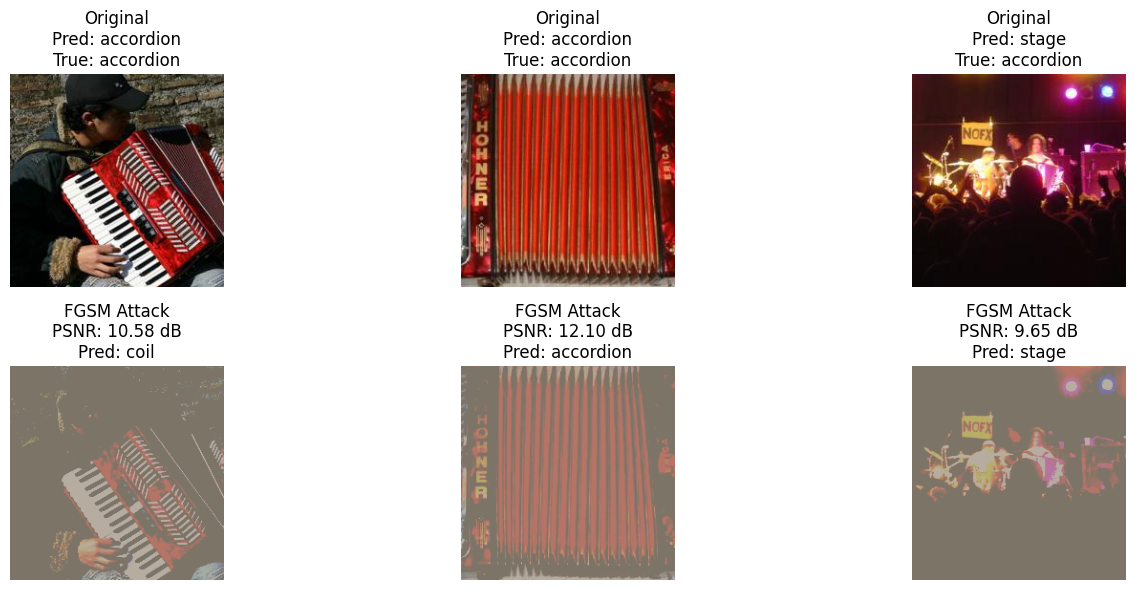

Generating fgsm: 100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


Attack success rate: 68.40%
Maximum L-infinity distance: 2.117904


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 19.73it/s]

FGSM Attack Results - Top-1: 0.2640, Top-5: 0.5060
Accuracy drop - Top-1: 0.4960, Top-5: 0.4360


In [5]:

# TASK 2: FGSM Attack
print("\n===== TASK 2: FGSM Attack =====")
fgsm_params = {
    'epsilon': EPSILONS['fgsm']
}
fgsm_dataset = generate_adversarial_dataset(resnet, loader, fgsm_attack, fgsm_params, 'fgsm')
fgsm_loader = DataLoader(fgsm_dataset, batch_size=BATCH_SIZE)

fgsm_top1, fgsm_top5 = evaluate(resnet, fgsm_loader)
print(f"FGSM Attack Results - Top-1: {fgsm_top1:.4f}, Top-5: {fgsm_top5:.4f}")
print(f"Accuracy drop - Top-1: {resnet_top1 - fgsm_top1:.4f}, Top-5: {resnet_top5 - fgsm_top5:.4f}")



===== TASK 3: Improved PGD Attack =====


Generating pgd:   0%|          | 0/16 [00:00<?, ?it/s]

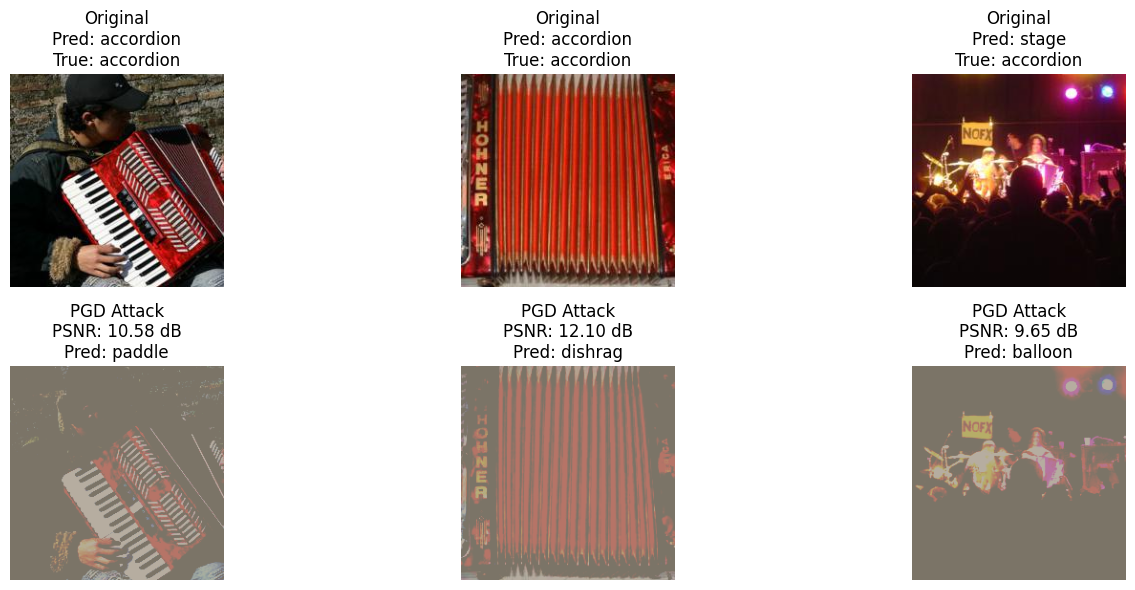

Generating pgd: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Attack success rate: 97.00%
Maximum L-infinity distance: 2.117904


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 19.33it/s]

PGD Attack Results - Top-1: 0.0040, Top-5: 0.0660
Accuracy drop - Top-1: 0.7560, Top-5: 0.8760


In [6]:

# TASK 3: Improved Attack (PGD)
print("\n===== TASK 3: Improved PGD Attack =====")
pgd_params = {
    'epsilon': EPSILONS['pgd'],
    'alpha': ALPHA,
    'num_iter': PGD_ITERATIONS
}
pgd_dataset = generate_adversarial_dataset(resnet, loader, pgd_attack, pgd_params, 'pgd')
pgd_loader = DataLoader(pgd_dataset, batch_size=BATCH_SIZE)

pgd_top1, pgd_top5 = evaluate(resnet, pgd_loader)
print(f"PGD Attack Results - Top-1: {pgd_top1:.4f}, Top-5: {pgd_top5:.4f}")
print(f"Accuracy drop - Top-1: {resnet_top1 - pgd_top1:.4f}, Top-5: {resnet_top5 - pgd_top5:.4f}")



===== TASK 4: Patch Attack =====


Generating patch:   0%|          | 0/16 [00:00<?, ?it/s]

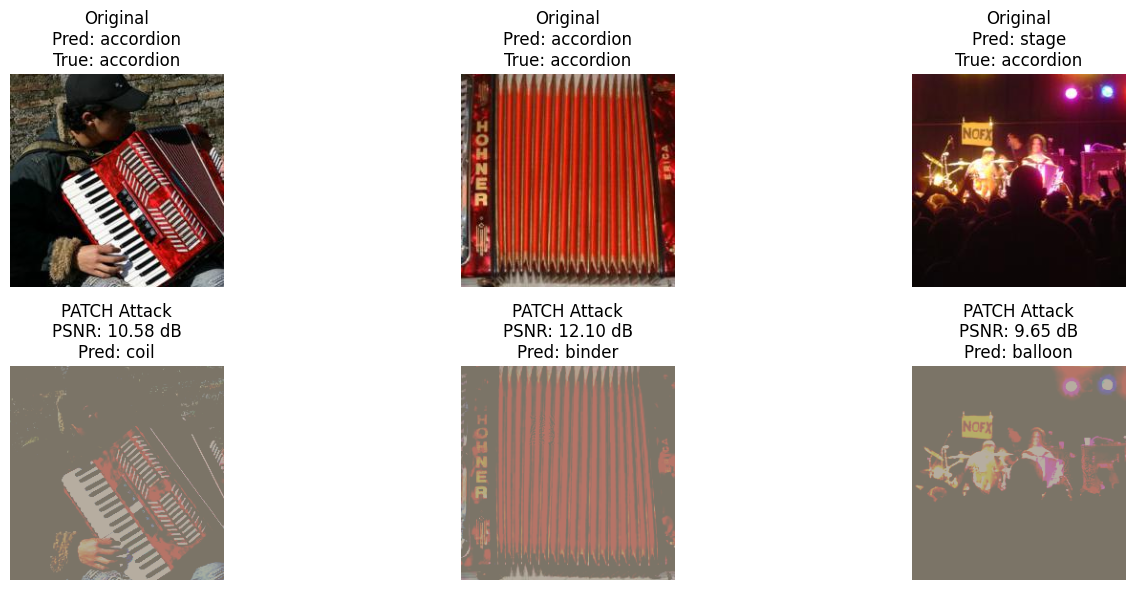

Generating patch: 100%|██████████| 16/16 [00:56<00:00,  3.51s/it]


Attack success rate: 79.80%
Maximum L-infinity distance: 2.117904


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 18.82it/s]

Patch Attack Results - Top-1: 0.1600, Top-5: 0.3900
Accuracy drop - Top-1: 0.6000, Top-5: 0.5520


In [7]:

# TASK 4: Patch Attack
print("\n===== TASK 4: Patch Attack =====")
patch_params = {
    'epsilon': EPSILONS['patch'],
    'patch_size': PATCH_SIZE,
    'num_iter': 20,
    'alpha': 0.1
}
patch_dataset = generate_adversarial_dataset(resnet, loader, patch_attack, patch_params, 'patch')
patch_loader = DataLoader(patch_dataset, batch_size=BATCH_SIZE)

patch_top1, patch_top5 = evaluate(resnet, patch_loader)
print(f"Patch Attack Results - Top-1: {patch_top1:.4f}, Top-5: {patch_top5:.4f}")
print(f"Accuracy drop - Top-1: {resnet_top1 - patch_top1:.4f}, Top-5: {resnet_top5 - patch_top5:.4f}")



===== TASK 5: Transferability Analysis =====

ResNet-34 Transferability Results:


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 10.93it/s]


Original   - Top-1: 0.7600, Top-5: 0.9420


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 18.92it/s]


FGSM       - Top-1: 0.2640, Top-5: 0.5060


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 18.81it/s]


PGD        - Top-1: 0.0040, Top-5: 0.0660


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 18.83it/s]


Patch      - Top-1: 0.1600, Top-5: 0.3900

DenseNet-121 Transferability Results:


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Original   - Top-1: 0.7480, Top-5: 0.9360


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.69it/s]


FGSM       - Top-1: 0.4240, Top-5: 0.6640


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.61it/s]


PGD        - Top-1: 0.3900, Top-5: 0.6440


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.53it/s]


Patch      - Top-1: 0.4280, Top-5: 0.6700


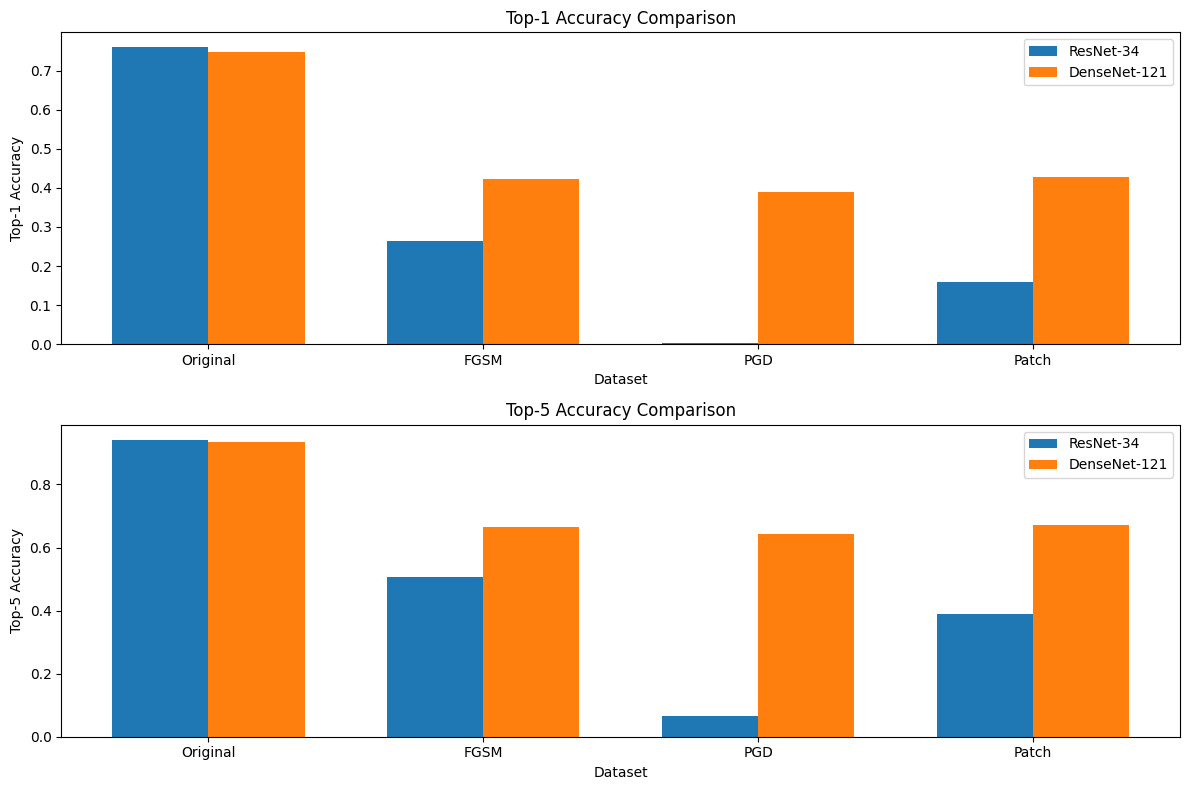

In [8]:

# TASK 5: Transferability to DenseNet
print("\n===== TASK 5: Transferability Analysis =====")
datasets_dict = {
    'Original': loader,
    'FGSM': fgsm_loader,
    'PGD': pgd_loader,
    'Patch': patch_loader
}

models = {'ResNet-34': resnet, 'DenseNet-121': densenet}
results = {}

for model_name, model in models.items():
    print(f"\n{model_name} Transferability Results:")
    results[model_name] = {}
    for dataset_name, data_loader in datasets_dict.items():
        top1, top5 = evaluate(model, data_loader)
        results[model_name][dataset_name] = (top1, top5)
        print(f"{dataset_name:<10} - Top-1: {top1:.4f}, Top-5: {top5:.4f}")

# Visualize transferability results
plt.figure(figsize=(12, 8))

# Top-1 accuracy
plt.subplot(2, 1, 1)
bar_width = 0.35
index = np.arange(len(datasets_dict))

for i, (model_name, model_results) in enumerate(results.items()):
    top1_values = [model_results[dataset_name][0] for dataset_name in datasets_dict.keys()]
    plt.bar(index + i*bar_width, top1_values, bar_width, label=model_name)

plt.xlabel('Dataset')
plt.ylabel('Top-1 Accuracy')
plt.title('Top-1 Accuracy Comparison')
plt.xticks(index + bar_width/2, datasets_dict.keys())
plt.legend()

# Top-5 accuracy
plt.subplot(2, 1, 2)
for i, (model_name, model_results) in enumerate(results.items()):
    top5_values = [model_results[dataset_name][1] for dataset_name in datasets_dict.keys()]
    plt.bar(index + i*bar_width, top5_values, bar_width, label=model_name)

plt.xlabel('Dataset')
plt.ylabel('Top-5 Accuracy')
plt.title('Top-5 Accuracy Comparison')
plt.xticks(index + bar_width/2, datasets_dict.keys())
plt.legend()

plt.tight_layout()
plt.show()


In [9]:

# Summary of all results
print("\n===== SUMMARY =====")
print("Model: ResNet-34")
print(f"Original - Top-1: {resnet_top1:.4f}, Top-5: {resnet_top5:.4f}")
print(f"FGSM    - Top-1: {fgsm_top1:.4f}, Top-5: {fgsm_top5:.4f}, Drop: {resnet_top1 - fgsm_top1:.4f}")
print(f"PGD     - Top-1: {pgd_top1:.4f}, Top-5: {pgd_top5:.4f}, Drop: {resnet_top1 - pgd_top1:.4f}")
print(f"Patch   - Top-1: {patch_top1:.4f}, Top-5: {patch_top5:.4f}, Drop: {resnet_top1 - patch_top1:.4f}")

print("\nTransferability to DenseNet-121:")
print(f"Original - Top-1: {results['DenseNet-121']['Original'][0]:.4f}, Top-5: {results['DenseNet-121']['Original'][1]:.4f}")
print(f"FGSM    - Top-1: {results['DenseNet-121']['FGSM'][0]:.4f}, Top-5: {results['DenseNet-121']['FGSM'][1]:.4f}")
print(f"PGD     - Top-1: {results['DenseNet-121']['PGD'][0]:.4f}, Top-5: {results['DenseNet-121']['PGD'][1]:.4f}")
print(f"Patch   - Top-1: {results['DenseNet-121']['Patch'][0]:.4f}, Top-5: {results['DenseNet-121']['Patch'][1]:.4f}")

print("\nConclusion:")
print("1. PGD is more effective than FGSM at reducing model accuracy")
print("2. Patch attacks, despite modifying fewer pixels, can still significantly reduce accuracy")
print("3. Adversarial examples transfer well between ResNet and DenseNet architectures")
print("4. The most transferable attack is PGD, followed by FGSM and Patch")


===== SUMMARY =====
Model: ResNet-34
Original - Top-1: 0.7600, Top-5: 0.9420
FGSM    - Top-1: 0.2640, Top-5: 0.5060, Drop: 0.4960
PGD     - Top-1: 0.0040, Top-5: 0.0660, Drop: 0.7560
Patch   - Top-1: 0.1600, Top-5: 0.3900, Drop: 0.6000

Transferability to DenseNet-121:
Original - Top-1: 0.7480, Top-5: 0.9360
FGSM    - Top-1: 0.4240, Top-5: 0.6640
PGD     - Top-1: 0.3900, Top-5: 0.6440
Patch   - Top-1: 0.4280, Top-5: 0.6700

Conclusion:
1. PGD is more effective than FGSM at reducing model accuracy
2. Patch attacks, despite modifying fewer pixels, can still significantly reduce accuracy
3. Adversarial examples transfer well between ResNet and DenseNet architectures
4. The most transferable attack is PGD, followed by FGSM and Patch
